In [1]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 164 (delta 28), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (164/164), 1.48 MiB | 1.66 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=9022c35b12678c4998f42c274a56c9ddfcafb8b6cad06ed19b1c8a9f962d4fd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ot_hzg3u/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc


In [2]:
from deepflows.data_generators import celeba
from deepflows import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp
from deepflows.data_generators import stochasticShapes
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms

device = utils.set_gpu(True)

Note: GPU is not available


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!





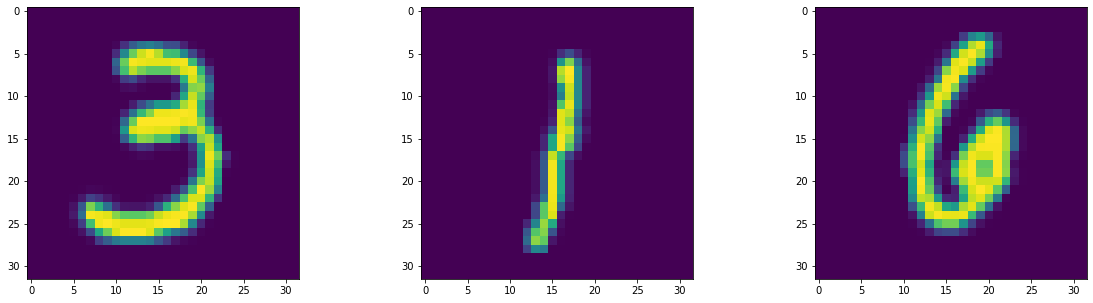

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform);
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform);

train_loader_uncon = DataLoader(mnist_trainset, batch_size=64, shuffle=True, pin_memory=False)
test_loader_uncon = DataLoader(mnist_testset, batch_size=64, shuffle=False, pin_memory=False)

x_plot2 = next(iter(train_loader_uncon))[0].permute(0,2,3,1)

fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].imshow(x_plot2[0].squeeze(dim=-1))
ax[1].imshow(x_plot2[1].squeeze(dim=-1))
ax[2].imshow(x_plot2[2].squeeze(dim=-1))
plt.show()

In [4]:
logabs = lambda x: torch.log(torch.abs(x))


class WeightNormConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0,
                 bias=True):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(
            nn.Conv2d(in_dim, out_dim, kernel_size,
                      stride=stride, padding=padding, bias=bias))

    def forward(self, x):
        return self.conv(x)

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0))

    def forward(self, x):
        return x + self.block(x)


class SimpleResnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_filters=64, n_blocks=4):
        super(SimpleResnet, self).__init__()
        layers = [WeightNormConv2d(in_channels, n_filters, (3, 3), stride=1, padding=1),
                  nn.ReLU()]
        for _ in range(n_blocks):
            layers.append(ResnetBlock(n_filters))
        layers.append(nn.ReLU())
        layers.append(WeightNormConv2d(n_filters, out_channels, (3, 3), stride=1, padding=1))
        self.resnet = nn.Sequential(*layers)

    def forward(self, x):
        return self.resnet(x)

In [5]:

logabs = lambda x: torch.log(torch.abs(x))

class InvConv2dLU(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
 
        weight = np.random.randn(in_channel, in_channel)
        q, _ = la.qr(weight)
        w_p, w_l, w_u = la.lu(q.astype(np.float32))
        w_s = np.diag(w_u)
        w_u = np.triu(w_u, 1)
        u_mask = np.triu(np.ones_like(w_u), 1)
        l_mask = u_mask.T
 
        w_p = torch.from_numpy(w_p)
        w_l = torch.from_numpy(w_l)
        w_s = torch.from_numpy(w_s)
        w_u = torch.from_numpy(w_u)
 
        self.register_buffer('w_p', w_p)
        self.register_buffer('u_mask', torch.from_numpy(u_mask))
        self.register_buffer('l_mask', torch.from_numpy(l_mask))
        self.register_buffer('s_sign', torch.sign(w_s))
        self.register_buffer('l_eye', torch.eye(l_mask.shape[0]))
        self.w_l = nn.Parameter(w_l)
        self.w_s = nn.Parameter(logabs(w_s))
        self.w_u = nn.Parameter(w_u)
 
    def forward(self, input,reverse=False):
        _, _, height, width = input.shape
 
        weight = self.calc_weight()
 
 
        logdet = self.w_s
        if reverse:
          out=F.conv2d(input, weight.squeeze().inverse().unsqueeze(2).unsqueeze(3))
        else:
          out = F.conv2d(input, weight)
        return out, logdet.unsqueeze(0).unsqueeze(2).unsqueeze(3)
 
    def calc_weight(self):
        weight = (
            self.w_p
            @ (self.w_l * self.l_mask + self.l_eye)
            @ ((self.w_u * self.u_mask) + torch.diag(self.s_sign * torch.exp(self.w_s)))
        )
 
        return weight.unsqueeze(2).unsqueeze(3)
 

class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super(ActNorm, self).__init__()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False
 
    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True)
                self.log_scale.data = - torch.log(
                    torch.std(x.permute(1, 0, 2, 3).reshape(self.n_channels, -1), dim=1).reshape(1, self.n_channels, 1, 1))
                self.initialized = True
                result = x * torch.exp(self.log_scale) + self.shift
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale
 
class AffineCheckerboardTransform(nn.Module):
    def __init__(self, type=1.0):
        super(AffineCheckerboardTransform, self).__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet(in_channels=1,
                                   out_channels=1 * 2, n_blocks=1)
 
    def build_mask(self, type=1.0):
        mask = np.arange(32).reshape(-1, 1) + np.arange(32)
        mask = np.mod(type + mask, 2)
        mask = mask.reshape(-1, 1, 32, 32)
        return torch.tensor(mask.astype('float32')).to(device)
 
    def forward(self, x, reverse=False):
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        x_ = x * mask
 
        log_s, t = self.resnet(x_).split(n_channels, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)
 
        if reverse: 
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s
 
class AffineChannelTransform(nn.Module):
    def __init__(self, modify_top):
        super(AffineChannelTransform, self).__init__()
        self.modify_top = modify_top
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet(in_channels=2, out_channels=4)
 

    def forward(self, x, reverse=False):
        n_channels = x.shape[1]
        if self.modify_top:
            on, off = x.split(n_channels // 2, dim=1)
        else:
            off, on = x.split(n_channels // 2, dim=1)
        log_s, t = self.resnet(off).split(n_channels // 2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
 
        if reverse:  
            on = (on - t) * torch.exp(-log_s)
        else:
            on = on * torch.exp(log_s) + t
 
        if self.modify_top:
            return torch.cat([on, off], dim=1), torch.cat([log_s, torch.zeros_like(log_s)], dim=1)
        else:
            return torch.cat([off, on], dim=1), torch.cat([torch.zeros_like(log_s), log_s], dim=1)
 
class UnconditionalGlow(nn.Module):
    def __init__(self):
        super(UnconditionalGlow, self).__init__()
 
        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.checker_transforms1 = nn.ModuleList([
            AffineCheckerboardTransform(1.0),
            ActNorm(1),
            AffineCheckerboardTransform(0.0),
            ActNorm(1),
            AffineCheckerboardTransform(1.0),
            ActNorm(1),
            AffineCheckerboardTransform(0.0)
        ])
        self.conv1x1n1=InvConv2dLU(4)
        self.channel_transforms = nn.ModuleList([
            AffineChannelTransform(True),
            ActNorm(4),
            AffineChannelTransform(False),
            ActNorm(4),
            AffineChannelTransform(True),
        ])
        self.conv1x1n2=InvConv2dLU(1)
        self.checker_transforms2 = nn.ModuleList([
            AffineCheckerboardTransform(1.0),
            ActNorm(1),
            AffineCheckerboardTransform(0.0),
            ActNorm(1),
            AffineCheckerboardTransform(1.0)
        ])
 
    def squeeze(self, x):
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x
 
    def undo_squeeze(self, x):
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x
 
    def g(self, z):
        x = z
        for op in reversed(self.checker_transforms2):
            x, _ = op.forward(x, reverse=True)
        x, _ = self.conv1x1n2.forward(x,reverse=True)
        x = self.squeeze(x)
        for op in reversed(self.channel_transforms):
            x, _ = op.forward(x, reverse=True)
        x, _ = self.conv1x1n1.forward(x,reverse=True)
        x = self.undo_squeeze(x)
        for op in reversed(self.checker_transforms1):
            x, _ = op.forward(x, reverse=True)
        return x
 
    def f(self, x):
        z, log_det = x, torch.zeros_like(x)
        for op in self.checker_transforms1:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        z, log_det = self.squeeze(z), self.squeeze(log_det)
        z, delta_log_det = self.conv1x1n1.forward(z)
        log_det += delta_log_det
        for op in self.channel_transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        z, log_det = self.undo_squeeze(z), self.undo_squeeze(log_det)
        z, delta_log_det = self.conv1x1n2.forward(z)
        log_det += delta_log_det
        for op in self.checker_transforms2:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det
 
    def log_prob(self, x):
        z, log_det = self.f(x)
        return torch.sum(log_det, [1, 2, 3]) + torch.sum(self.prior.log_prob(z), [1, 2, 3])
 
    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 1, 32, 32])
        return self.g(z)

In [6]:
class Solver(object):
    def __init__(self, learning_rate=5e-4, n_epochs=128):
        self.train_loader, self.val_loader = self.create_loaders()
        self.log_interval = 100
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)

    def build(self):
        self.flow = UnconditionalGlow().to(device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)

    def create_loaders(self):
        train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True, pin_memory=False)
        test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=False, pin_memory=False)
        return train_loader, test_loader

    def preprocess(self, x, reverse=False, dequantize=True):
        if reverse:
            x = 1.0 / (1 + torch.exp(-x))
            x -= 0.05
            x /= 0.9
            return x
        else:
            # dequantization
            if dequantize:
                x += torch.distributions.Uniform(0.0, 1.0).sample(x.shape).to(device)
            max_value=4.0
            x /= max_value

            # logit operation
            x *= 0.9
            x += 0.05
            logit = torch.log(x) - torch.log(1.0 - x)
            log_det = torch.nn.functional.softplus(logit) + torch.nn.functional.softplus(-logit) \
                      + torch.log(torch.tensor(0.9)) - torch.log(torch.tensor(max_value))
            return logit, torch.sum(log_det, dim=(1, 2, 3))

    def train(self):
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1

            self.flow.train()
            self.batch_loss_history = []

            for batch_i, image in enumerate(tqdm(
                    self.train_loader, desc='Batch', leave=False)):

                batch_i += 1
                image = Variable(image[0]).to(device)
                
                log_prob = self.flow.log_prob(image)
                

                batch_loss = -torch.mean(log_prob) / (1 * 32.0 * 32.0)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                batch_loss = float(batch_loss.data)
                self.batch_loss_history.append(batch_loss)

            epoch_loss = np.mean(self.batch_loss_history)
            tqdm.write(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')

            if epoch_i % 5 == 0:
                self.save_model("GlowConditional{}.model".format(str(epoch_i)))
            train_losses.append(epoch_loss)
            val_losses.append(self.get_loss(self.val_loader))
            np.save("train_losses.npy", np.array(train_losses))
            np.save("val_losses.npy", np.array(val_losses))

        self.save_model("GlowConditional_final.model")
        return train_losses, val_losses

    def get_loss(self, loader):
        """Compute error on provided data set"""
        errors = []

        # cuda.synchronize()
        start = time.time()

        self.flow.eval()

        for image in loader:
            with torch.no_grad():
                image = image[0].to(device)
                log_prob = self.flow.log_prob(image)
                

                loss = -torch.mean(log_prob) / (1 * 32.0 * 32.0)
                error = float(loss.data)
                errors.append(error)
        # cuda.synchronize()

        time_test = time.time() - start
        log_string = f'Calc done! | It took {time_test:.1f}s | '
        log_string += f'Loss: {np.mean(errors):.2f}'
        tqdm.write(log_string)
        return np.mean(errors)

    def sample(self, num_samples):
        with torch.no_grad():
            raw_samples = self.flow.sample(num_samples).cpu()
            samples = self.preprocess(raw_samples, reverse=True)
            return samples.cpu().numpy()

    def save_model(self, filename):
        torch.save(self.flow, filename)

    def load_model(self, filename):
        self.flow = torch.load(filename, map_location="cpu")

In [7]:
solver = Solver(n_epochs=10, learning_rate=0.001)
solver.build()
train, val = solver.train()

KeyboardInterrupt: ignored